<a href="https://colab.research.google.com/github/LelouchFT/MagasinXYZ/blob/main/TrainPotabilteEau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, learning_curve,RandomizedSearchCV,StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
# 📦 Importing libraries
import pandas as pd
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV,SelectFromModel,SelectKBest
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,f1_score

import warnings
warnings.filterwarnings("ignore")





# 📂 Load the dataset (update the path as needed)
df = pd.read_csv("/content/water_potability.csv")


df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
# 📦 Importing libraries
'''
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(),cmap= 'coolwarm',annot = True)
fig.savefig('heatmap.png')
plt.show()
print(df.head().T)
df.info()
'''
colonne = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

#print(df.columns.tolist())
#xtrain,xtest,y_train,y_test = train_test_split(df.drop("Potability",axis = 1), y ,stratify=y, test_size = 0.2, random_state = 42)

def preprocessing(data):
 y = df.Potability
 xtrain,xtest,y_train,y_test = train_test_split(data.drop("Potability",axis = 1), y ,stratify=y, test_size = 0.2, random_state = 42)
 num_features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
 num_transformer = Pipeline([
     ("imputer", SimpleImputer(strategy = 'mean')),
     ("scaler", MinMaxScaler())
 ])

 preprocessor = ColumnTransformer([
     ("num", num_transformer,num_features)
 ])


       # Encode categorical variables and split features/target as needed
 X_train = num_transformer.fit_transform(xtrain)
 X_test = num_transformer.transform(xtest)
 new_columns = num_features

       # Convert in Pandas DataFrame
 X_train = pd.DataFrame(X_train, columns=new_columns)
 X_test = pd.DataFrame(X_test, columns=new_columns)

 return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = preprocessing(df)



def train_model2(model,param,xtrain,ytrain,xtest,ytest):
       print("", model.__class__.__name__)
       cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

       grid = GridSearchCV(model,param,cv=cv,n_jobs = -1,scoring='f1',verbose=1)
       grid.fit(xtrain,ytrain)
       # Meilleurs paramètres
       print("Meilleurs paramètres :", grid.best_params_)
       #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
       # Meilleur modèle
       best_model = grid.best_estimator_
       print("Score sur les données de test:", best_model.score(X_test, y_test))
       ypred = best_model.predict(xtest)
       print( classification_report(ypred, ytest))
       acc = f1_score(ypred, ytest)

       return best_model,ypred, acc




def train_model(model,xtrain,ytrain,xtest,ytest):
       print("", model)
       model.fit(xtrain,ytrain)

       ypred = model.predict(xtest)
       print( classification_report(ypred, ytest))
       acc = accuracy_score(ypred, ytest)

       return model ,ypred, acc





# 🤖 Baseline prediction Model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
param_random = {
    'n_estimators': [100, 200,300,400],
    'max_depth': [None, 10, 20,40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
param_svc = { "C" :[0.1,1,10,100] ,
                 "kernel": ["linear","poly","sigmoid","rbf"] ,
                 "gamma" : ["scale","auto" , 0.01, 0.05] ,
                 "degree" : [2,3,4,5]
               }
param_reg = {  "C" : [0.01,0.1 ,1,10,100],
                          "penalty" : ["l1","l2","none","elasticnet"] ,
                   "solver" : ["liblinear" ,"saga", "newton-cg", "lbfgs"] ,
                        }
param_tree = { "criterion":["gini","entropy"] ,
                           "max_depth" :[30,40,60,20],
                           "min_samples_split" :[1,2,4,6,5],
                     "max_features" : ["sqrt" ,"log2",None,0.5],
                     "min_samples_leaf" :[1,2,4,5]
                  }


#xgb = XGBClassifier(objective='multi:softprob', num_class=4, use_label_encoder=False, eval_metric='mlogloss')

param_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_lambda': [0.1, 1, 5],
    'reg_alpha': [0, 0.5, 1]
}

log_reg = LogisticRegression(solver='liblinear', class_weight='balanced')

log_params = {
    'C': [0.01, 0.1, 1, 10, 100]
}


svm_model = (SVC(), log_params)
forest_model = (RandomForestClassifier(),param_random)
tree_model = ( DecisionTreeClassifier() , param_tree )
reg_model = ( log_reg , param_xgb)

models =[ (log_reg,log_params) ]

param_knn = {
    'n_neighbors': [10,5,4,7,3],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn = [(KNeighborsClassifier(), param_knn)]


'''
selector = RFECV(best,step =1 , min_features_to_select = 12 , cv = 5)
selector2 = SelectFromModel(decisionT,threshold = 'mean')

selector.fit_transform(X_train,y_train)
print(X_train.columns[selector.get_support()])

print(selector.get_support())

selector.fit(X_train,y_train)
print(selector.ranking_)
print(selector.get_support())
print(selector.cv_results_["mean_test_score"])
best.fit(X_train,y_train)
print(f"train : {best.score(X_train,y_train)}")
print(f"test : {best.score(X_test,y_test)}")
'''

'\nselector = RFECV(best,step =1 , min_features_to_select = 12 , cv = 5)\nselector2 = SelectFromModel(decisionT,threshold = \'mean\')\n\nselector.fit_transform(X_train,y_train)\nprint(X_train.columns[selector.get_support()])\n\nprint(selector.get_support())\n\nselector.fit(X_train,y_train)\nprint(selector.ranking_)\nprint(selector.get_support())\nprint(selector.cv_results_["mean_test_score"])\nbest.fit(X_train,y_train)\nprint(f"train : {best.score(X_train,y_train)}")\nprint(f"test : {best.score(X_test,y_test)}")\n'

 LogisticRegression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meilleurs paramètres : {'C': 0.01}
Score sur les données de test: 0.5182926829268293
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       284
           1       0.61      0.42      0.50       372

    accuracy                           0.52       656
   macro avg       0.53      0.53      0.52       656
weighted avg       0.54      0.52      0.51       656

Accuracy:  0.4968152866242038


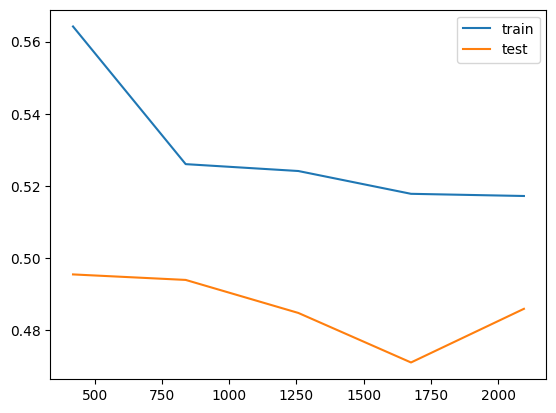

In [ ]:
for model in models:
       mod , param = model
       best_model,ypred,acc = train_model2(mod,param, X_train,y_train,X_test,y_test)
       print("Accuracy: ",acc)

       joblib.dump(mod, 'modele_xgbacc.joblib')
       N,train_score,val_score = learning_curve(mod,X_train,y_train,train_sizes = np.linspace(0.2,1.0,5),cv= 5)
       plt.plot(N,train_score.mean(axis =1),label = "train")
       plt.plot(N,val_score.mean(axis =1),label = "test")
       plt.legend()
       plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, recall_score,accuracy_score
from sklearn.model_selection import learning_curve
import numpy as np


# 1. Création des modèles (repris)
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42)

voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2]
)

# 2. Entraînement
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Score recall :", recall_scorer(y_test,y_pred ))
print(classification_report(y_test, y_pred))


# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 4. Courbe d’apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train, y_train, cv=5, scoring=recall_score, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage - VotingClassifier")
plt.legend()
plt.grid(True)
plt.show()

# Rapport texte
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 1. Création des modèles (repris)
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42)

voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2]
)

# 2. Entraînement
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Score accuracy :", recall_score(y_test,y_pred ))
print(classification_report(y_test, y_pred))


# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 4. Courbe d’apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train, y_train, cv=5, scoring=recall_score, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage - VotingClassifier")
plt.legend()
plt.grid(True)
plt.show()

# Rapport texte
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 1. Création des modèles (repris)
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42)

voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2]
)

# 2. Entraînement
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Score accuracy :", recall_score(y_test,y_pred ))
print(classification_report(y_test, y_pred))


# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 4. Courbe d’apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train, y_train, cv=5, scoring=recall_score, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage - VotingClassifier")
plt.legend()
plt.grid(True)
plt.show()

# Rapport texte
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# 1. Création des modèles (repris)
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)
xgb = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8, use_label_encoder=False, eval_metric='logloss', random_state=42)

voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2]
)

# 2. Entraînement
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
print("Score accuracy :", recall_score(y_test,y_pred ))
print(classification_report(y_test, y_pred))


# 3. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 4. Courbe d’apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train, y_train, cv=5, scoring=recall_score, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Précision")
plt.title("Courbe d'apprentissage - VotingClassifier")
plt.legend()
plt.grid(True)
plt.show()

# Rapport texte
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

Score recall : 0.5960156249999999
Score accuracy : 0.6539634146341463
              precision    recall  f1-score   support

           0       0.67      0.86      0.75       400
           1       0.60      0.33      0.43       256

    accuracy                           0.65       656
   macro avg       0.64      0.60      0.59       656
weighted avg       0.64      0.65      0.63       656



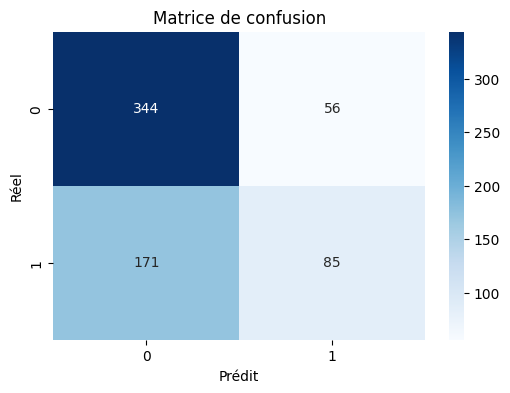

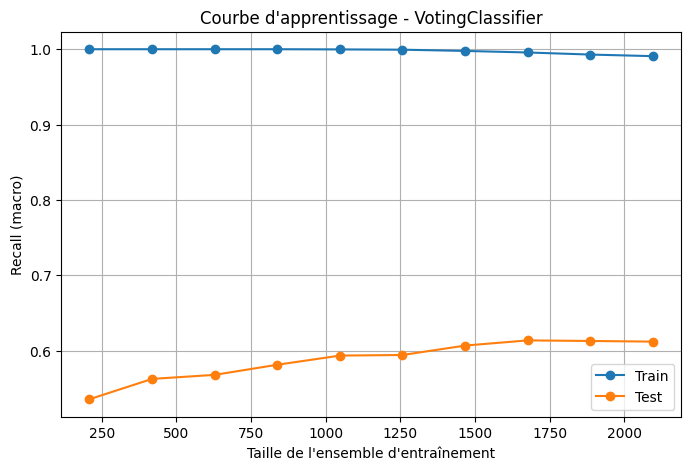

In [ ]:
# Importations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import learning_curve

# 1. Création des modèles
rf = RandomForestClassifier(
    n_estimators=200,
    random_state = 42,
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1
)

xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2]
)

# 2. Entraînement du modèle
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

# 3. Évaluation
print("Score recall :", recall_score(y_test, y_pred, average='macro'))
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 4. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 5. Courbe d’apprentissage
recall_scorer = make_scorer(recall_score, average='macro')
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train, y_train,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Recall (macro)")
plt.title("Courbe d'apprentissage - VotingClassifier")
plt.legend()
plt.grid(True)
plt.show()

Score recall : 0.616171875
Score accuracy : 0.635670731707317
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       400
           1       0.53      0.53      0.53       256

    accuracy                           0.64       656
   macro avg       0.62      0.62      0.62       656
weighted avg       0.63      0.64      0.64       656



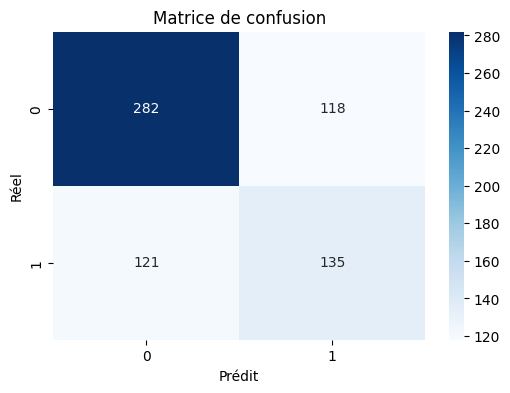

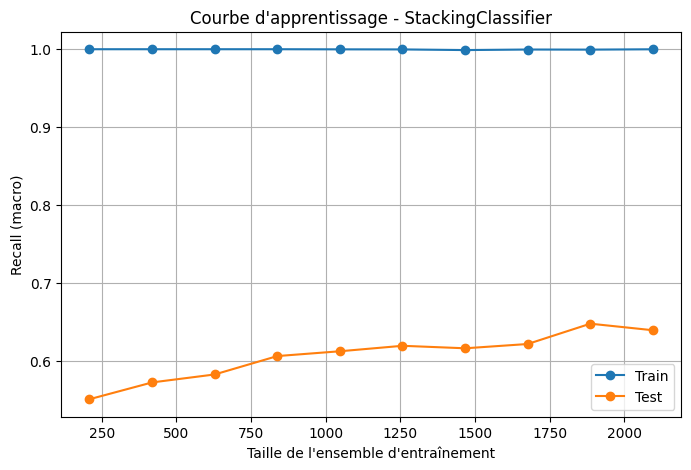

In [ ]:
# Importations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import learning_curve

# 1. Création des modèles de base
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 2. Modèle méta
meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# 3. StackingClassifier
stacking = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=meta_model,
    cv=5,
    passthrough=False,  # tu peux mettre True pour inclure les features originales
    n_jobs=-1
)

# 4. Entraînement du modèle
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)

# 5. Évaluation
print("Score recall :", recall_score(y_test, y_pred, average='macro'))
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 7. Courbe d’apprentissage
recall_scorer = make_scorer(recall_score, average='macro')
train_sizes, train_scores, test_scores = learning_curve(
    stacking, X_train, y_train,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Recall (macro)")
plt.title("Courbe d'apprentissage - StackingClassifier")
plt.legend()
plt.grid(True)
plt.show()

Nombre de features sélectionnées : 5
Indices des features sélectionnées : [0 1 2 3 4]
Score recall : 0.617890625
Score accuracy : 0.6326219512195121
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       400
           1       0.53      0.55      0.54       256

    accuracy                           0.63       656
   macro avg       0.62      0.62      0.62       656
weighted avg       0.64      0.63      0.63       656



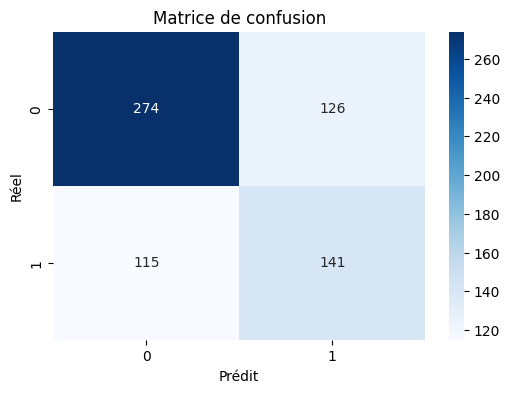

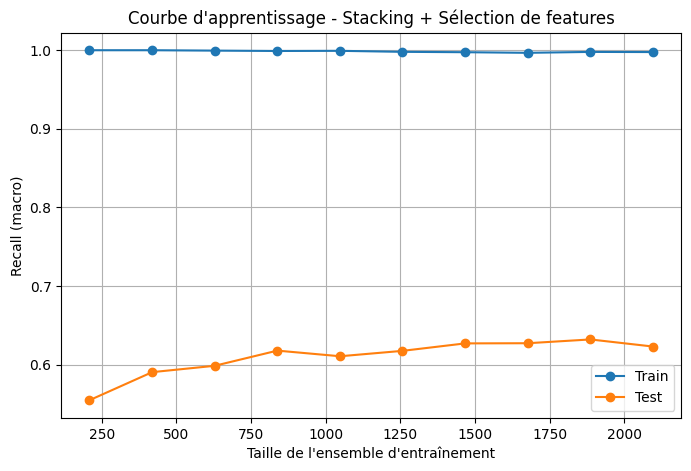

In [ ]:
# Importations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import learning_curve

# 1. Sélection des meilleures features avec RandomForest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

# SelectFromModel (auto-threshold ou threshold="mean" possible)
selector = SelectFromModel(rf_selector, prefit=True, threshold="mean")
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Affichage des features sélectionnées (facultatif)
selected_features = selector.get_support(indices=True)
print(f"Nombre de features sélectionnées : {len(selected_features)}")
print(f"Indices des features sélectionnées : {selected_features}")

# 2. Création des modèles
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced')

stacking = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# 3. Entraînement avec les features sélectionnées
stacking.fit(X_train_sel, y_train)
y_pred = stacking.predict(X_test_sel)

# 4. Évaluation
print("Score recall :", recall_score(y_test, y_pred, average='macro'))
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 5. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 6. Courbe d’apprentissage
recall_scorer = make_scorer(recall_score, average='macro')
train_sizes, train_scores, test_scores = learning_curve(
    stacking, X_train_sel, y_train,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Recall (macro)")
plt.title("Courbe d'apprentissage - Stacking + Sélection de features")
plt.legend()
plt.grid(True)
plt.show()

Nombre de features sélectionnées : 5
Features sélectionnées : ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate']
Score recall : 0.614296875
Score accuracy : 0.6676829268292683
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       400
           1       0.62      0.37      0.47       256

    accuracy                           0.67       656
   macro avg       0.65      0.61      0.61       656
weighted avg       0.66      0.67      0.64       656



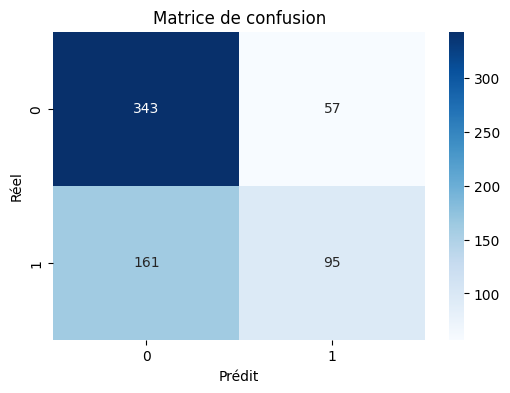

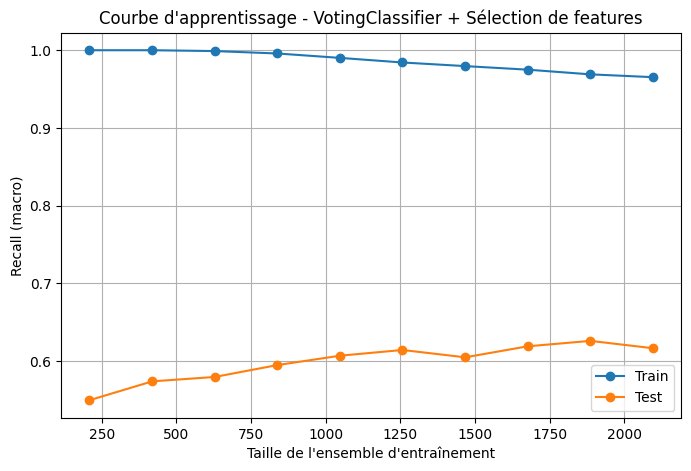

In [ ]:
# Importations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import learning_curve

# 1. Sélection des meilleures features avec RandomForest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

selector = SelectFromModel(rf_selector, prefit=True, threshold="mean")
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Affichage des noms de features sélectionnées (si X_train est un DataFrame)
selected_columns = X_train.columns[selector.get_support()]
print(f"Nombre de features sélectionnées : {len(selected_columns)}")
print("Features sélectionnées :", selected_columns.tolist())

# 2. Création des modèles
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2],
    n_jobs=-1
)

# 3. Entraînement avec les features sélectionnées
voting.fit(X_train_sel, y_train)
y_pred = voting.predict(X_test_sel)

# 4. Évaluation
print("Score recall :", recall_score(y_test, y_pred, average='macro'))
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 5. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 6. Courbe d’apprentissage
recall_scorer = make_scorer(recall_score, average='macro')
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train_sel, y_train,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Recall (macro)")
plt.title("Courbe d'apprentissage - VotingClassifier + Sélection de features")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Affichage des noms des features sélectionnées
import pandas as pd

# Si X_train est un DataFrame
selected_columns = X_train.columns[selector.get_support()]
print("Features sélectionnées :")
print(selected_columns.tolist())

Features sélectionnées :
['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate']


Nombre de features sélectionnées : 5
Features sélectionnées : ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate']
Score recall : 0.63203125
Score accuracy : 0.6661585365853658
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       400
           1       0.59      0.48      0.53       256

    accuracy                           0.67       656
   macro avg       0.65      0.63      0.63       656
weighted avg       0.66      0.67      0.66       656



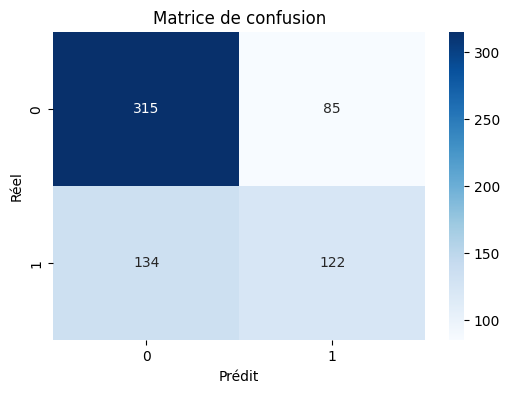

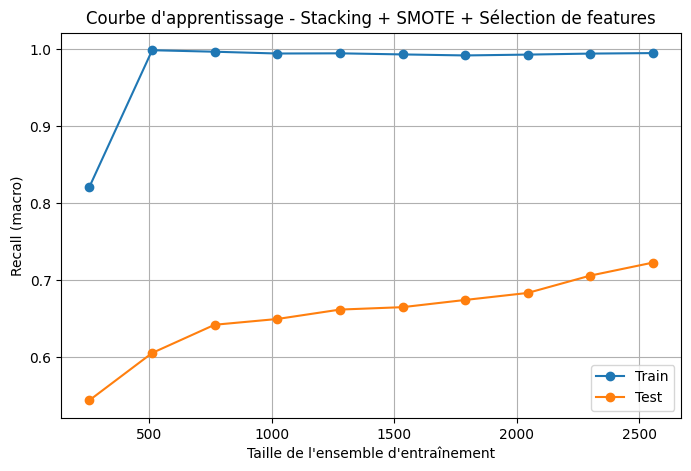

In [32]:
# Importations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE

# 1. Sélection des meilleures features avec RandomForest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

selector = SelectFromModel(rf_selector, prefit=True, threshold="mean")
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Affichage des noms de features sélectionnées
selected_columns = X_train.columns[selector.get_support()]
print(f"Nombre de features sélectionnées : {len(selected_columns)}")
print("Features sélectionnées :", selected_columns.tolist())

# 2. Application de SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sel, y_train)

# 3. Création des modèles de base et du méta-modèle
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

meta_model = LogisticRegression(max_iter=1000, class_weight='balanced',C=0.01)

stacking = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)
joblib.dump(mod, 'modele_stacking.joblib')
# 4. Entraînement sur les données rééquilibrées par SMOTE
stacking.fit(X_train_resampled, y_train_resampled)
y_pred = stacking.predict(X_test_sel)

# 5. Évaluation
print("Score recall :", recall_score(y_test, y_pred, average='macro'))
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 6. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 7. Courbe d’apprentissage
recall_scorer = make_scorer(recall_score, average='macro')
train_sizes, train_scores, test_scores = learning_curve(
    stacking, X_train_resampled, y_train_resampled,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Recall (macro)")
plt.title("Courbe d'apprentissage - Stacking + SMOTE + Sélection de features")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier  # ou ton modèle
from sklearn.datasets import make_classification

# Exemple de données

# Définir les scorers
recall_scorer = make_scorer(recall_score, average='macro')
f1_scorer = make_scorer(f1_score, average='macro')

Nombre de features sélectionnées : 5
Features sélectionnées : ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate']
Score recall : 0.63515625
Score accuracy : 0.663109756097561
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       400
           1       0.58      0.51      0.54       256

    accuracy                           0.66       656
   macro avg       0.64      0.64      0.64       656
weighted avg       0.66      0.66      0.66       656



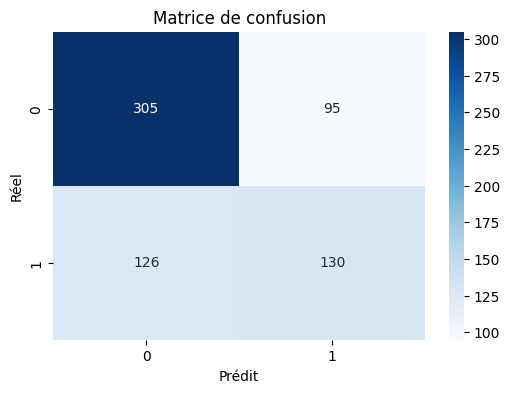

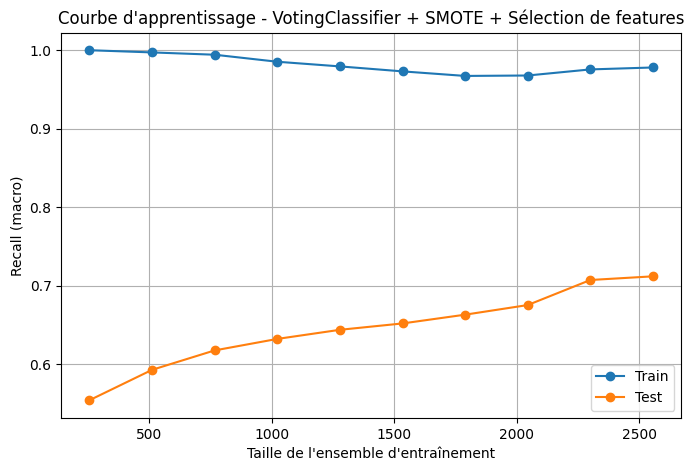

In [ ]:
# Importations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE

# 1. Sélection des meilleures features avec RandomForest
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

selector = SelectFromModel(rf_selector, prefit=True, threshold="mean")
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Affichage des noms des features sélectionnées
selected_columns = X_train.columns[selector.get_support()]
print(f"Nombre de features sélectionnées : {len(selected_columns)}")
print("Features sélectionnées :", selected_columns.tolist())

# 2. Rééquilibrage des classes avec SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sel, y_train)

# 3. Création des modèles de base
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 4. Création du VotingClassifier
voting = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft',
    weights=[1, 2],
    n_jobs=-1
)

# 5. Entraînement du modèle sur les données rééquilibrées
voting.fit(X_train_resampled, y_train_resampled)
y_pred = voting.predict(X_test_sel)
joblib.dump(voting, 'modele_voting.joblib')
# 6. Évaluation des performances
print("Score recall :", recall_score(y_test, y_pred, average='macro'))
print("Score accuracy :", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 7. Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 8. Courbe d’apprentissage
recall_scorer = make_scorer(recall_score, average='macro')
train_sizes, train_scores, test_scores = learning_curve(
    voting, X_train_resampled, y_train_resampled,
    cv=5,
    scoring=recall_scorer,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Train")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Test")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Recall (macro)")
plt.title("Courbe d'apprentissage - VotingClassifier + SMOTE + Sélection de features")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp /content/modele_xgbacc.joblib /content/drive/MyDrive/

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(class_weight='balanced', random_state=42)

lgbm_params = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50]
}
gbm = (lgbm,lgbm_params)
#grid_lgbm = GridSearchCV(lgbm, lgbm_params, scoring='f1_score', cv=cv)

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

#grid_xgb = GridSearchCV(xgb, xgb_params, scoring=scorer, cv=cv)

In [ ]:
from sklearn.svm import SVC

svm = SVC(class_weight='balanced')

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(svm, svm_params, scoring=scorer, cv=cv)

In [ ]:
import os

print("Nombre de cœurs disponibles :", os.cpu_count())

Nombre de cœurs disponibles : 2


In [ ]:
from joblib import cpu_count

print("Nombre de cœurs utilisables par joblib :", cpu_count())

Nombre de cœurs utilisables par joblib : 2
